A very quick look at the evolving coronavirus cases in LA County, starting with Jan 21st, when the first case got diagnosed in the county. Data comes from the LA County Public Health website:
http://publichealth.lacounty.gov/media/Coronavirus/
I am updating the data as it comes in. 

In [106]:
import requests 
from bs4 import BeautifulSoup 
  
#URL = "http://www.values.com/inspirational-quotes"
URL = "http://publichealth.lacounty.gov/media/Coronavirus/"

r = requests.get(URL) 
  
soup = BeautifulSoup(r.content, 'html5lib') 
the_text = soup.get_text()
st_date = the_text
date_md = [int(s) for s in st_date.split() if s.isdigit()]
#print(soup.prettify())  
new_data = []
table = soup.findAll('div', attrs = {'class':'counter-block counter-text'})
dt_txt = soup.find('div', attrs = {'class': 'col-md-12 center'})
##print("The length of this thing is:",len(dt_txt))
##print(dt_txt)
##more_dt = dt_txt.find('small')
##st_date = more_dt.text
##date_md = [int(s) for s in st_date.split() if s.isdigit()]
all_text = dt_txt.get_text()
new_dt = [int(s) for s in all_text.split() if s.isdigit()]
print(new_dt)
if len(table) > 2:
    print('Need to take a look, format of page has changed')
for row in table: 
    print(row.text)
    new_data.append(row.text)
     
print(new_data)
 

[]
231
2
['231', '2']


            confirmed cases  deaths  hospitalized  daily cases month
date                                                                
2020-01-22                0       0           0.0            0   Jan
2020-01-23                0       0           0.0            0   Jan
2020-01-24                0       0           0.0            0   Jan
2020-01-25                0       0           0.0            0   Jan
2020-01-26                1       0           0.0            1   Jan


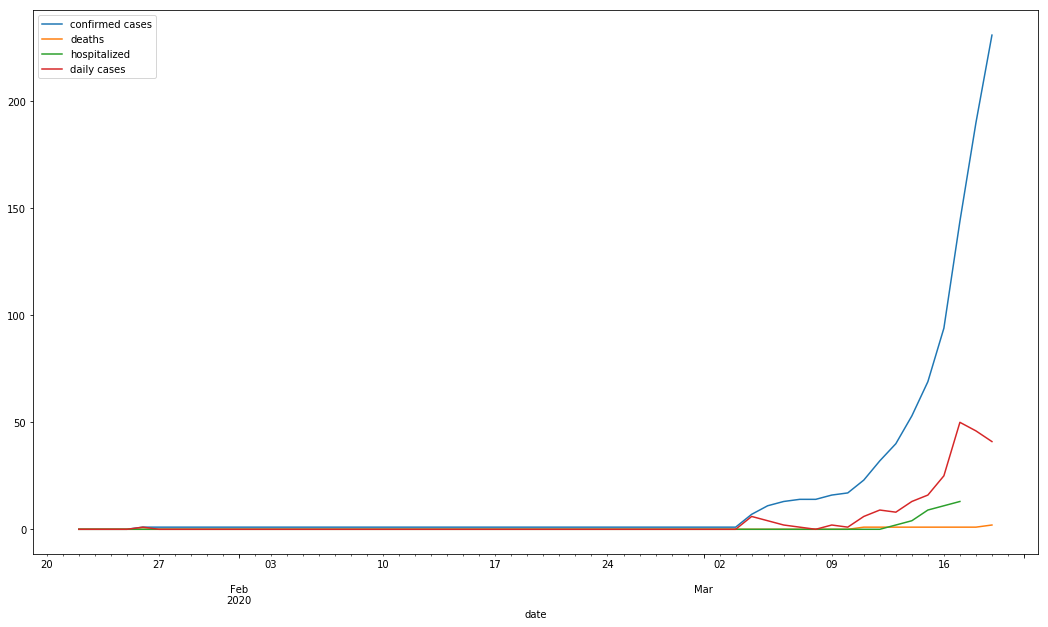

In [112]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

df = pd.read_csv('LACountyCovid.csv', header=0, index_col=0, squeeze=True)
df.index = pd.to_datetime(df.index)
df.index.name = 'date'
print(df.head())

df.plot(figsize=(18,10))
plt.show()



Text(0.5,1,'New confirmed cases')

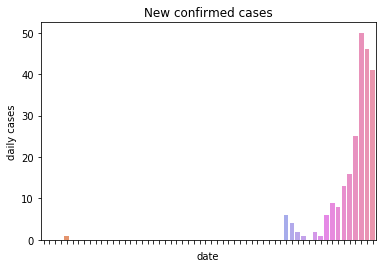

In [151]:
pl = sns.barplot(x = df.index, y = df['daily cases'])
_=plt.xticks(np.arange(df.shape[0])[::1], df.index[0:0:1], rotation=35)

pl.set_title('New confirmed cases')